# 뉴스 요약봇 만들기
-----
### 프로젝트 - 뉴스기사 요약해보기

## 실습목표

>* 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
>* ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
>* 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

## 순서
> **Step1.** 시계열 데이터 준비<br>
**Step2.** 각종 전처리 수행<br>
**Step3.** 시계열 안정성 분석<br>
**Step4.** 학습, 테스트 데이터셋 생성<br>
**Step5.** 적정 ARIMA 모수 찾기<br>
**Step6.** ARIMA 모델 훈련과 테스트<br>
**Step7.** 다른 주식 종목 예측해 보기

## 용어정리
---

**✓ 시계열 예측(Time-Series Prediction)**이란?
>* 시계열이란 시간 순서대로 발생한 데이터의 수열
>* 간단한 수식의 형태
  <math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>Y</mi>
  <mo>=</mo>
  <mo fence="false" stretchy="false">{</mo>
  <msub>
    <mi>Y</mi>
    <mi>t</mi>
  </msub>
  <mo>:</mo>
  <mi>t</mi>
  <mo>&#x2208;</mo>
  <mi>T</mi>
  <mo fence="false" stretchy="false">}</mo>
  <mtext>, where&#xA0;</mtext>
  <mi>T</mi>
  <mtext>&#xA0;is the index set</mtext>
</math>
>* 안정적(Stationary) 데이터에 대해서만 미래 예측이 가능
>>* **"안정적(Stationary)이다는 것은 시계열 데이터의 통계적 특성이 변하지 않는다."**
>* **완벽한 미래 예측을 보장하지 않음!!!**

>* **ARIMA(Auto-regressive Integrated Moving Average)**이란?
>> * 탄탄한 통계학 이론적 기반
>> * 
>> * 
>> * 
>* **Prophet**이란?
>> * 페이스북에서 발표
> * LSTM 등 딥러닝을 활용하는 방법

**✓ NLTK**란?
>* **N**atural **L**anguage **T**oolkit의 축약어
>* 이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장
>* 의미를 분석하고 요약하는데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있음!

우리는 NLTK를 이용해 다운로드받은 리뷰 파일에서 불용어를 제거하는 작업을 진행할 예정입니다.<br>

**✓ seq2seq(sequence-to-sequence)**란?
>* 인코더와 디코더의 구조로 구성된 딥러닝 아키텍처
>* 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델
>* 주로 뉴럴 기계번역에 사용 ➡️ 원문을 요약문으로 번역 과정과 비슷

**✓ 인공 신경망으로 텍스트 요약 훈련시키기**
1. seq2seq를 사용합니다.
2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

### Step1. 시계열 데이터 준비
---
**✓ 그럼 데이터를 준비해 볼까요?**
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

✓ 날짜가 인덱스(index) 역할

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

### Step2. 각종 전처리 수행

**✓ 결측치 처리**

In [2]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

**✓ 로그 변환**

In [3]:
ts_log = np.log(ts)

### Step3. 시계열 안정성 분석
---
**✓ 정성적 그래프 분석<br>
✓ 정량적 Augmented Dicky-Fuller Test<br>
✓ 시계열 분해(Time Series Decomposition)<br>
✓ Residual 안정성 확인**

In [4]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

NameError: name 'plot_rolling_statistics' is not defined

In [5]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

NameError: name 'residual' is not defined

### Step4. 학습, 테스트 데이터셋 생성
---
**✓ 학습, 테스트 데이터셋 분리**

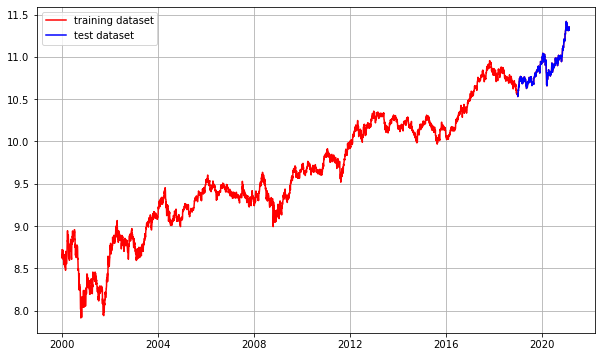

In [6]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Step5. 적정 ARIMA 모수 찾기
---
**✓ ACF, PACF 그려보기 -> p,q 구하기<br>
✓ 차분 안정성 확인 -> d 구하기**

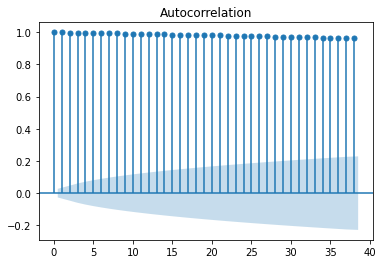

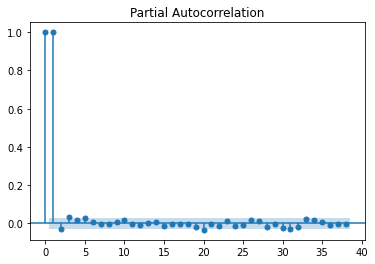

In [7]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

NameError: name 'augmented_dickey_fuller_test' is not defined

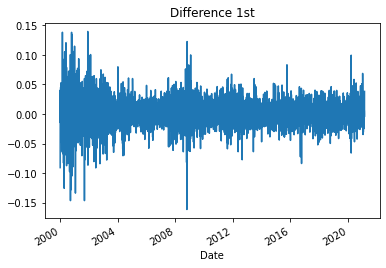

In [8]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Step6. ARIMA 모델 훈련과 테스트
---
**✓ ARIMA 모델 빌드와 훈련<br>
✓ 모델 테스트 및 플로팅<br>
✓ 최종 예측 모델 정확도 측정(MAPE)**

In [9]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4784
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11274.679
Method:                       css-mle   S.D. of innovations              0.023
Date:                Wed, 03 Mar 2021   AIC                         -22543.358
Time:                        22:25:29   BIC                         -22523.939
Sample:                             1   HQIC                        -22536.537
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.104      0.270      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

/home/aiffel-dj49/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj49/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

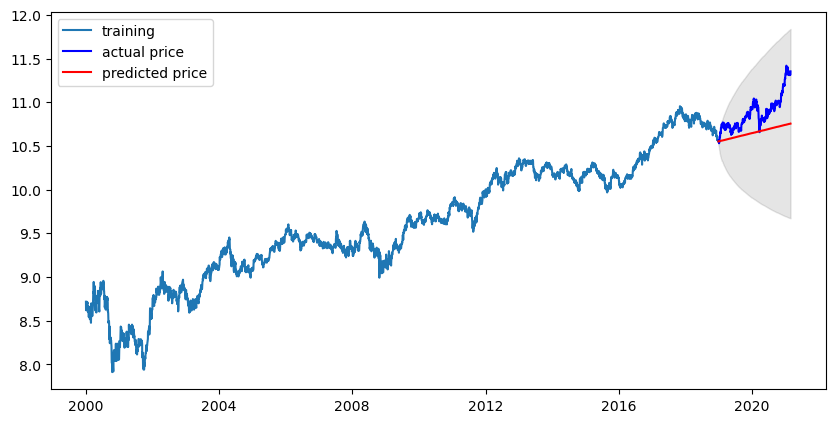

In [10]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  225496540.9985021
MAE:  11761.247623447354
RMSE:  15016.542245087652
MAPE: 19.59%


### Step7. 다른 주식 종목 예측해 보기
---
**✓ 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기**

# 루브릭 평가 기준
---
번호|평가문항|상세기준
---|---|---
1 |시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음
2 |ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3 |예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨

# 회고
---